In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [14]:
df = pd.read_parquet("../data/processed/salinity_00_train_data.parquet")
cols = ["temperature_00", "oxygen_00", "nitrate_00", "phosphate_00"]

In [15]:
def encode_geospatial_features(df: pd.DataFrame) -> np.ndarray:
    lat_rad = np.radians(df["lat"].to_numpy())
    lon_rad = np.radians(df["lon"].to_numpy())

    sin_lat = np.sin(lat_rad)
    cos_lat = np.cos(lat_rad)
    sin_lon = np.sin(lon_rad)
    cos_lon = np.cos(lon_rad)

    depth = df["depth"].to_numpy(dtype=np.float32)
    norm_depth = (depth - depth.min()) / (depth.max() - depth.min())

    geo_features = np.stack([sin_lat, cos_lat, sin_lon, cos_lon, norm_depth], axis=1)
    return geo_features.astype(np.float32)

In [16]:
class Scaler:
    def __init__(self, mean: dict[str, float], std: dict[str, float]):
        self.mean = mean
        self.std = std
        self.cols = list(mean.keys())

    @classmethod
    def from_dataframe(cls, df, cols):
        mean = {col: df[col].mean() for col in cols}
        std = {col: df[col].std() for col in cols}
        return cls(mean, std)

    def normalize(self, tensor: torch.Tensor, cols: list[str]) -> torch.Tensor:
        for i, col in enumerate(cols):
            tensor[:, i] = (tensor[:, i] - self.mean[col]) / self.std[col]
        return tensor

    def denormalize(self, tensor: torch.Tensor, cols: list[str]) -> torch.Tensor:
        means = torch.tensor([self.mean[c] for c in cols], dtype=tensor.dtype, device=tensor.device)
        stds  = torch.tensor([self.std[c]  for c in cols], dtype=tensor.dtype, device=tensor.device)
        return tensor * stds + means

    def mae(self, reconstructed: torch.Tensor, ground_truth: torch.Tensor, cols: list[str]) -> float:
        rec_denorm = self.denormalize(reconstructed.clone(), cols)
        gt_denorm = self.denormalize(ground_truth.clone(), cols)
        return torch.abs(rec_denorm - gt_denorm).mean().item()
    
    def masked_mae(self, reconstructed: torch.Tensor, ground_truth: torch.Tensor, mask: torch.Tensor, cols: list[str]) -> float:
        rec_denorm = self.denormalize(reconstructed.clone(), cols)
        gt_denorm = self.denormalize(ground_truth.clone(), cols)
        
        abs_error = torch.abs(rec_denorm - gt_denorm)
        masked_error = abs_error * mask

        mae = masked_error.sum() / mask.sum().clamp(min=1.0)
        return mae.item()

In [17]:
df = df.dropna(subset=cols).reset_index(drop=True)
scaler = Scaler.from_dataframe(df, cols)
geo = encode_geospatial_features(df)
x = df[cols].to_numpy(dtype=np.float32)

x_full = np.concatenate([x, geo], axis=1)

In [18]:
X = torch.tensor(x_full)
X = scaler.normalize(X.clone(), cols)

In [19]:
class MaskedVoxelDataset(Dataset):
    def __init__(self, X: torch.Tensor, mask_ratio=0.5):
        self.X = X
        self.mask_ratio = mask_ratio
        self.mask_cols = 4

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        mask = torch.ones_like(x, dtype=torch.bool)
        for i in range(self.mask_cols):
            if torch.rand(1).item() < self.mask_ratio:
                mask[i] = False
        return x, mask

loader = DataLoader(MaskedVoxelDataset(X, mask_ratio=0.5), batch_size=256, shuffle=True)

In [20]:
class MaskedAutoEncoder(nn.Module):
    def __init__(self, in_dim=9, maskable_dim=4, embed_dim=64, depth=4):
        super().__init__()
        self.in_dim = in_dim
        self.maskable_dim = maskable_dim

        self.mask_token = nn.Parameter(torch.zeros(in_dim))

        layers = []
        for _ in range(depth):
            layers += [
                nn.Linear(embed_dim if layers else in_dim, embed_dim),
                nn.GELU(),
                nn.LayerNorm(embed_dim)
            ]
        self.encoder = nn.Sequential(*layers)

        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, in_dim)
        )

    def forward(self, x, mask):
        x = torch.where(mask, x, self.mask_token)
        z = self.encoder(x)
        return self.decoder(z)

In [21]:
def masked_mse(pred, target, mask):
    diff = (pred - target)[~mask]
    return (diff ** 2).sum() / diff.numel() 

In [22]:
model = MaskedAutoEncoder(in_dim=9, embed_dim=128).cuda()
opt = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=300)
for epoch in range(20):
    model.train()
    total_loss = 0
    for x, mask in loader:
        x, mask = x.cuda(), mask.cuda()
        loss = masked_mse(model(x, mask), x, mask)
        loss.backward(); opt.step(); opt.zero_grad()

        total_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}: loss = {total_loss:.4f}")

Epoch 1: loss = 130.5234
Epoch 2: loss = 71.3278
Epoch 3: loss = 62.2911
Epoch 4: loss = 55.8565
Epoch 5: loss = 53.5648
Epoch 6: loss = 50.6710
Epoch 7: loss = 50.1540
Epoch 8: loss = 47.8136
Epoch 9: loss = 46.5755
Epoch 10: loss = 46.1245
Epoch 11: loss = 46.0613
Epoch 12: loss = 44.7918
Epoch 13: loss = 43.9661
Epoch 14: loss = 43.6284
Epoch 15: loss = 42.8740
Epoch 16: loss = 43.3238
Epoch 17: loss = 42.5026
Epoch 18: loss = 42.1499
Epoch 19: loss = 41.8490
Epoch 20: loss = 41.4806


In [25]:
import matplotlib.pyplot as plt

C:\Users\dosti\AppData\Local\Temp\ipykernel_20136\1769552319.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_by_depth = df_err.groupby("depth_bin")["abs_error"].mean()


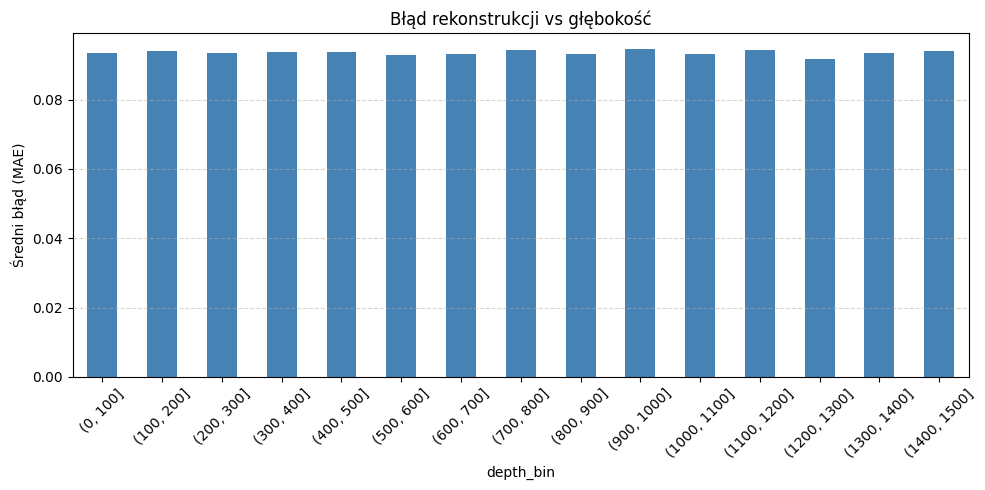

In [31]:
target_cols = ["temperature", "oxygen", "nitrate", "phosphate"]
target_len = len(target_cols)

offset = 0
all_preds = []
all_truth = []
all_depth = []

model.eval()
with torch.no_grad():
    for x, mask in loader:
        x = x.cuda()
        mask = mask.cuda()
        pred = model(x, mask)

        pred = pred[:, :target_len]

        batch_size = x.size(0)
        depth_batch = df["depth"].iloc[offset : offset + batch_size].to_numpy()
        offset += batch_size

        all_preds.append(pred.cpu().numpy())
        all_truth.append(x[:, :target_len].cpu().numpy())
        all_depth.append(depth_batch)

all_preds = np.vstack(all_preds)
all_truth = np.vstack(all_truth)
all_depth = np.concatenate(all_depth)

mae_per_sample = np.abs(all_preds - all_truth).mean(axis=1)

df_err = pd.DataFrame({
    "depth": all_depth,
    "abs_error": mae_per_sample,
})
df_err["depth_bin"] = pd.cut(df_err["depth"], bins=np.arange(0, 1600, 100))

mae_by_depth = df_err.groupby("depth_bin")["abs_error"].mean()

plt.figure(figsize=(10, 5))
mae_by_depth.plot(kind="bar", color="steelblue")
plt.ylabel("Średni błąd (MAE)")
plt.title("Błąd rekonstrukcji vs głębokość")
plt.xticks(rotation=45)
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

C:\Users\dosti\AppData\Local\Temp\ipykernel_20136\566937232.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_by_depth_feat = df_err.groupby("depth_bin")[target_cols].mean()


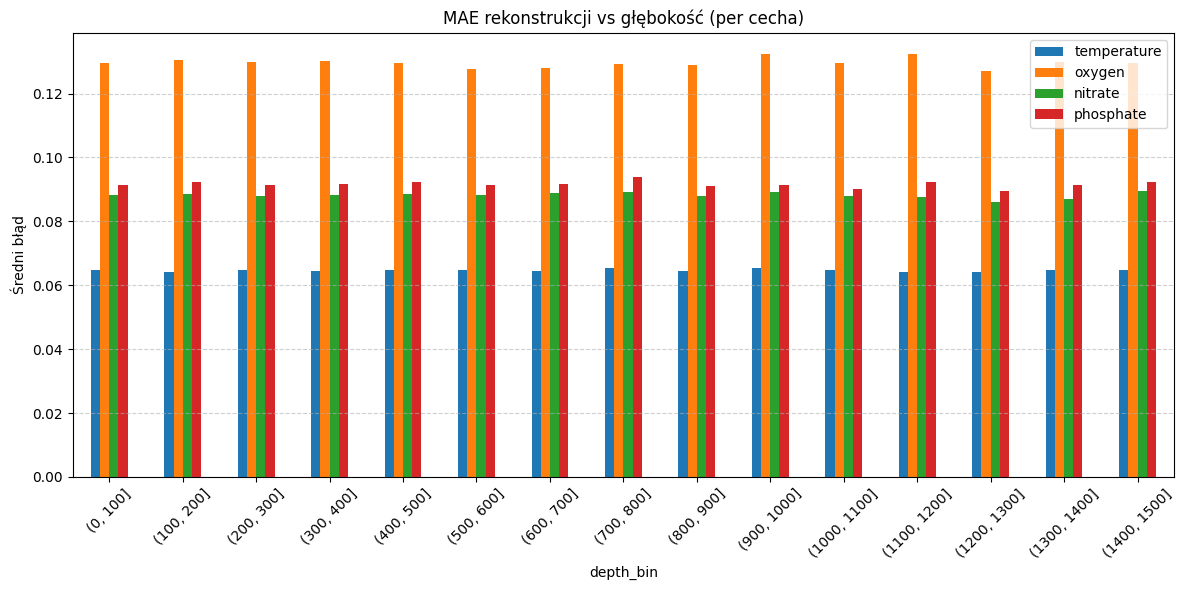

In [32]:
errors = np.abs(all_preds - all_truth)
df_err = pd.DataFrame(errors, columns=target_cols)
df_err["depth"] = all_depth
df_err["depth_bin"] = pd.cut(df_err["depth"], bins=np.arange(0, 1600, 100))

mae_by_depth_feat = df_err.groupby("depth_bin")[target_cols].mean()

mae_by_depth_feat.plot(kind="bar", figsize=(12, 6))
plt.title("MAE rekonstrukcji vs głębokość (per cecha)")
plt.ylabel("Średni błąd")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
